## Load the Dataset

In [8]:
import pandas as pd

df = pd.read_csv("data/data.csv",  encoding='ISO-8859-1')


df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Inspect the columns

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Clean the data

In [10]:
df = df[df['CustomerID'].notnull()]

In [17]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


##  RFM Feature Engineering

In [7]:
# Latest purchase date in the dataset
reference_date = df['InvoiceDate'].max()


rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


### Normalize skewed data

In [23]:
import numpy as np

rfm_log = rfm.copy()
rfm_log[['Recency', 'Frequency', 'Monetary']] = np.log1p(rfm_log[['Recency', 'Frequency', 'Monetary']])


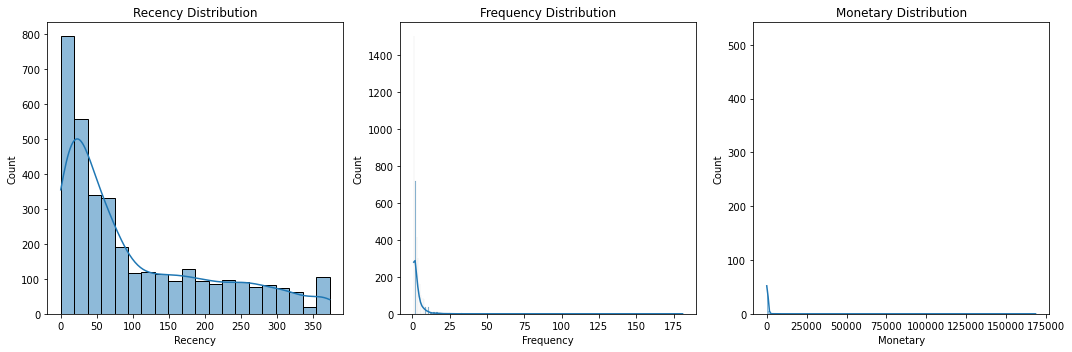

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.histplot(rfm[col], kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()


## Customer Segmentation with K-Means

### ormalize the Data

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])


### Use Elbow Method to Choose k (Number of Clusters)

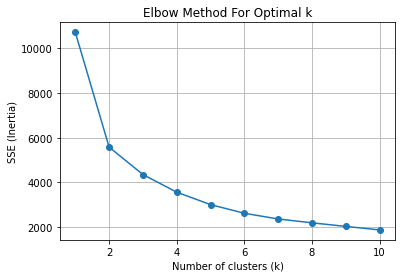

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


### Apply KMeans Clustering

In [44]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


### Analyze the Segments

In [45]:
rfm.groupby('Cluster').mean().round(2)

,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15307.84,31.20,6.25,742.01
1,15278.28,146.37,1.45,80.56


### Visualize the Clusters (2D & 3D)

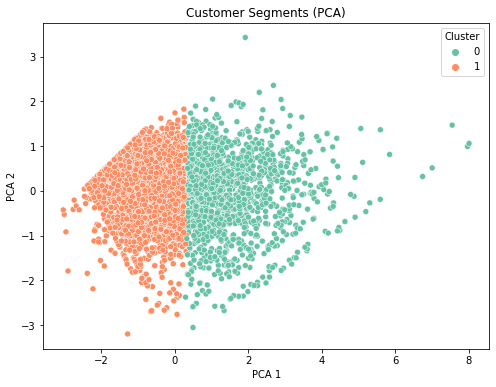

In [46]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1],
                hue=rfm['Cluster'], palette='Set2')
plt.title('Customer Segments (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [47]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)


,Recency,Frequency,Monetary
Cluster,,,
0,31.20,6.25,742.01
1,146.37,1.45,80.56


In [48]:
cluster_map = {
    0: 'Loyal Customers',
    1: 'Lost Customers'
}
rfm['Segment'] = rfm['Cluster'].map(cluster_map)


In [49]:
rfm['Segment'].value_counts()


Lost Customers     2249
Loyal Customers    1327
Name: Segment, dtype: int64

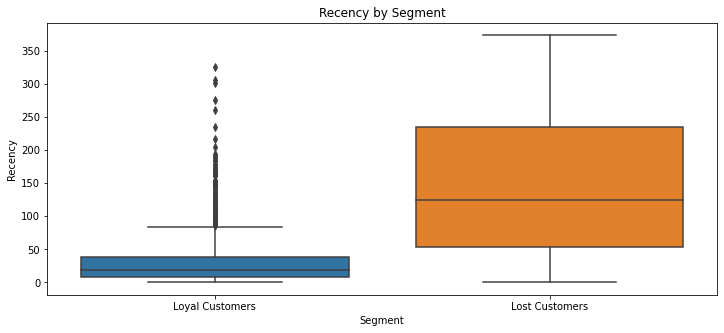

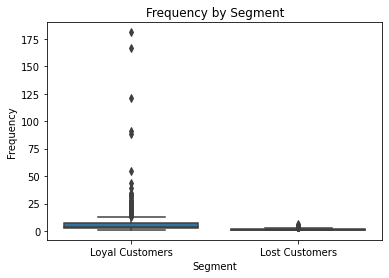

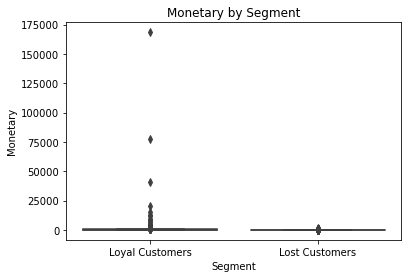

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.boxplot(data=rfm, x='Segment', y='Recency')
plt.title('Recency by Segment')
plt.show()

sns.boxplot(data=rfm, x='Segment', y='Frequency')
plt.title('Frequency by Segment')
plt.show()

sns.boxplot(data=rfm, x='Segment', y='Monetary')
plt.title('Monetary by Segment')
plt.show()


# Dashborad

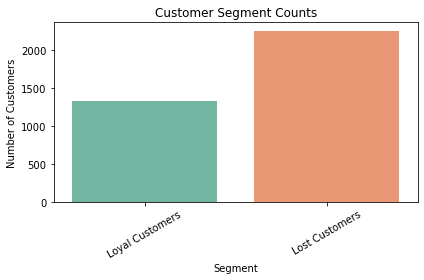

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=rfm, x='Segment', palette='Set2')
plt.title('Customer Segment Counts')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


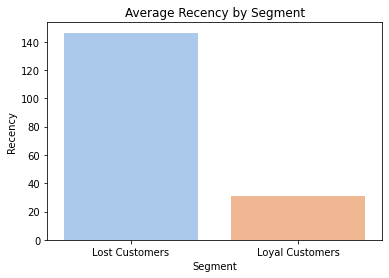

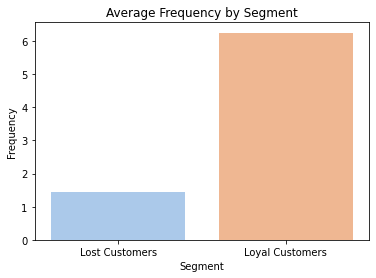

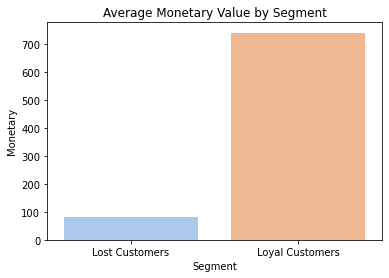

In [52]:
rfm_means = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Recency
sns.barplot(data=rfm_means, x='Segment', y='Recency', palette='pastel')
plt.title('Average Recency by Segment')
plt.show()

# Frequency
sns.barplot(data=rfm_means, x='Segment', y='Frequency', palette='pastel')
plt.title('Average Frequency by Segment')
plt.show()

# Monetary
sns.barplot(data=rfm_means, x='Segment', y='Monetary', palette='pastel')
plt.title('Average Monetary Value by Segment')
plt.show()


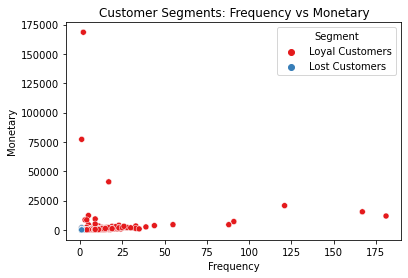

In [53]:
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='Set1')
plt.title('Customer Segments: Frequency vs Monetary')
plt.show()
